In [51]:
import pandas as pd
import subprocess
import os
import re
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import random as rd

In [2]:
df = pd.read_csv('../dataset/OpenPart.csv')
df.head()

,Case,Sample 1,Sample 2,Sample 3
0,00000072_000.png,1,5,1
1,00000150_002.png,5,5,3
2,00000181_061.png,4,4,3
3,00000211_019.png,4,4,2
4,00000211_041.png,3,5,2


In [3]:
def rename_file(num):
    def fun(row):
        row[0] = f'dataset/sample_{num}/{row[0]}'
        row[0] = row[0].replace('.png', f'_s{num}.png')
        return row
    return fun

def rename_expert_file(file_name):
    file_name = 'dataset/Expert/' + file_name[:-4] + '_expert.png'
    return file_name

In [19]:
df_s1 = df.iloc[:,[0,1]]
df_s1 = df_s1.rename(columns={"Case": "pred_path", "Sample 1": "review"})
df_s1['pred_path'].apply(rename_expert_file)
df_s1['true_mask'] = df_s1['pred_path'].apply(rename_expert_file)
df_s1 = df_s1.apply(rename_file(1), axis=1)
df_s1 = df_s1[['true_mask', 'pred_path', 'review']]
# df_s1

In [20]:
df_s2 = df.iloc[:,[0,1]]
df_s2 = df_s2.rename(columns={"Case": "pred_path", "Sample 1": "review"})
df_s2['true_mask'] = df_s2['pred_path'].apply(rename_expert_file)
df_s2 = df_s2.apply(rename_file(2), axis=1)
df_s2 = df_s2[['true_mask', 'pred_path', 'review']]
# df_s2

In [21]:
df_s3 = df.iloc[:,[0,1]]
df_s3 = df_s3.rename(columns={"Case": "pred_path", "Sample 1": "review"})
df_s3['true_mask'] = df_s3['pred_path'].apply(rename_expert_file)
df_s3 = df_s3.apply(rename_file(3), axis=1)
df_s3 = df_s3[['true_mask', 'pred_path', 'review']]
# df_s3

In [7]:
type_dict = {
    'DICE': 'Similarity',
    'JACRD': 'Similarity',
    'AUC': 'Similarity',
    'KAPPA': 'Similarity',
    'RNDIND': 'Similarity',
    'ADJRIND': 'Similarity',
    'ICCORR': 'Similarity',
    'VOLSMTY': 'Similarity',
    'MUTINF': 'Similarity',
    'HDRFDST': 'Distance',
    'AVGDIST': 'Distance',
    'MAHLNBS': 'Distance',
    'VARINFO': 'Distance',
    'GCOERR': 'Distance',
    'PROBDST': 'Distance',
    'SNSVTY': 'Classic Measures',
    'SPCFTY': 'Classic Measures',
    'PRCISON': 'Classic Measures',
    'FMEASR': 'Classic Measures',
    'ACURCY': 'Classic Measures',
    'FALLOUT': 'Classic Measures',
    'TP': 'Classic Measures',
    'FP': 'Classic Measures',
    'TN': 'Classic Measures',
    'FN': 'Classic Measures',
    'REFVOL': 'Classic Measures',
    'SEGVOL': 'Classic Measures',
}

In [8]:
new_df = pd.concat([df_s1, df_s2, df_s3]).reset_index(drop=True)

new_df['true_mask_pixels'] = 0
new_df['pred_mask_pixels'] = 0

for t in type_dict:
    new_df[t] = 0

In [9]:
def calculate(true_mask, pred_path, debug=False):    
    cmd_metrics = 'DICE,JACRD,AUC,KAPPA,RNDIND,ADJRIND,ICCORR,VOLSMTY,MUTINF,MAHLNBS,HDRFDST,VARINFO,GCOERR,PROBDST,SNSVTY,SPCFTY,PRCISON,FMEASR,ACURCY,FALLOUT,TP,FP,TN,FN,REFVOL,SEGVOL'
    
    metrics = subprocess.run(['./evaluate',
                              true_mask,
                              pred_path,
                             '-use', cmd_metrics],
                              cwd=os.path.realpath(os.path.join(os.getcwd(), '..')),
                              capture_output=True)
    
    metrics = metrics.stdout.decode("utf-8").strip()
    if debug:
        print(metrics)
    metrics = re.findall(r"([A-Z]+)\s+=\s([\.\d]+)\s+[\w\(\)\-,\s]+\s?$",
                         metrics, re.MULTILINE)
    
    return metrics

In [10]:
def is_img_empty(path):
    img = Image.open(f'../{path}').convert('L')
    np_img = np.array(img)
    np_img[np_img > 0] = 1
    return np.count_nonzero(np_img)

In [11]:
for i in tqdm(new_df.index, ncols='100%'):
    true_mask = new_df.loc[i, ['true_mask']][0]
    pred_path = new_df.loc[i, ['pred_path']][0]
    metrics = calculate(true_mask, pred_path)
    
    for metric_name, value in metrics:
        new_df.loc[i,[metric_name]] = value
        
    new_df.loc[i,['true_mask_pixels']] = is_img_empty(true_mask)
    new_df.loc[i,['pred_mask_pixels']] = is_img_empty(pred_path)
    

In [12]:
# new_df.to_csv('calculeted_metrics_fast_v4.csv')

In [13]:
new_df

,true_mask,pred_path,review,true_mask_pixels,pred_mask_pixels,DICE,JACRD,AUC,KAPPA,RNDIND,...,PRCISON,FMEASR,ACURCY,FALLOUT,TP,FP,TN,FN,REFVOL,SEGVOL
0,dataset/Expert/00000072_000_expert.png,dataset/sample_1/00000072_000_s1.png,1,0,2121,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,dataset/Expert/00000150_002_expert.png,dataset/sample_1/00000150_002_s1.png,5,2729,959,0.520065,0.351411,0.675705,0.519415,0.996630,...,1.000000,0.520065,0.998312,0.000000,959,0,1045847,1770,2729,959
2,dataset/Expert/00000181_061_expert.png,dataset/sample_1/00000181_061_s1.png,4,62059,173279,0.519559,0.350949,0.935726,0.473689,0.807597,...,0.352818,0.519559,0.892172,0.113676,61136,112143,874374,923,62059,173279
3,dataset/Expert/00000211_019_expert.png,dataset/sample_1/00000211_019_s1.png,4,138819,251580,0.708670,0.548791,0.936005,0.648735,0.806597,...,0.549853,0.708670,0.891534,0.124482,138332,113248,796509,487,138819,251580
4,dataset/Expert/00000211_041_expert.png,dataset/sample_1/00000211_041_s1.png,3,124276,285638,0.562957,0.391747,0.872117,0.476487,0.716678,...,0.403945,0.562957,0.829149,0.184200,115382,170256,754044,8894,124276,285638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,dataset/Expert/00011237_006_expert.png,dataset/sample_3/00011237_006_s3.png,3,39847,70040,0.519079,0.350511,0.837288,0.494596,0.904282,...,0.407196,0.519079,0.949601,0.041161,28520,41520,967209,11327,39847,70040
176,dataset/Expert/00011269_019_expert.png,dataset/sample_3/00011269_019_s3.png,1,3351,60618,0.000000,0.000000,0.471002,0,0.885432,...,0.000000,0.000000,0.938994,0.057995,0,60618,984607,3351,3351,60618
177,dataset/Expert/00011355_011_expert.png,dataset/sample_3/00011355_011_s3.png,4,39493,195195,0.304123,0.179331,0.872778,0.257612,0.737018,...,0.182827,0.304123,0.844252,0.158072,35687,159508,849575,3806,39493,195195
178,dataset/Expert/00011450_000_expert.png,dataset/sample_3/00011450_000_s3.png,4,49848,9603,0.315453,0.187263,0.593943,0.304776,0.925389,...,0.976466,0.315453,0.961188,0.000226,9377,226,998502,40471,49848,9603


In [14]:
mistakes = new_df[(new_df['review'] == 5) & (new_df['true_mask_pixels'] == 0) & (new_df['pred_mask_pixels'] != 0)]
mistakes[['true_mask', 'pred_path', 'review', 'true_mask_pixels', 'pred_mask_pixels']]

,true_mask,pred_path,review,true_mask_pixels,pred_mask_pixels
75,dataset/Expert/00002597_000_expert.png,dataset/sample_2/00002597_000_s2.png,5,0,2020
91,dataset/Expert/00005215_000_expert.png,dataset/sample_2/00005215_000_s2.png,5,0,3363
119,dataset/Expert/00011502_001_expert.png,dataset/sample_2/00011502_001_s2.png,5,0,156024
179,dataset/Expert/00011502_001_expert.png,dataset/sample_3/00011502_001_s3.png,5,0,140561


In [15]:
from sklearn.model_selection import train_test_split
from catboost.utils import eval_metric
from catboost import CatBoostRegressor, Pool

In [55]:
new_df[(new_df['review'] == 1) & (new_df['true_mask_pixels'] != 0) & (new_df['pred_mask_pixels'] != 0)]

,true_mask,pred_path,review,true_mask_pixels,pred_mask_pixels,DICE,JACRD,AUC,KAPPA,RNDIND,...,PRCISON,FMEASR,ACURCY,FALLOUT,TP,FP,TN,FN,REFVOL,SEGVOL
27,dataset/Expert/00003973_008_expert.png,dataset/sample_1/00003973_008_s1.png,1,74644,175558,0.364410,0.222800,0.738645,0.293869,0.742683,...,0.259675,0.364410,0.848341,0.133449,45588,129970,843962,29056,74644,175558
35,dataset/Expert/00007034_016_expert.png,dataset/sample_1/00007034_016_s1.png,1,144984,160318,0.015486,0.007804,0.420749,0,0.591036,...,0.014746,0.015486,0.713350,0.174807,2364,157954,745638,142620,144984,160318
56,dataset/Expert/00011269_019_expert.png,dataset/sample_1/00011269_019_s1.png,1,3351,79494,0.000000,0.000000,0.461973,0,0.854470,...,0.000000,0.000000,0.920993,0.076054,0,79494,965731,3351,3351,79494
69,dataset/Expert/00000974_002_expert.png,dataset/sample_2/00000974_002_s2.png,1,25300,102351,0.396393,0.247189,0.962351,0.372099,0.863836,...,0.247189,0.396393,0.926518,0.075298,25300,77051,946225,0,25300,102351
76,dataset/Expert/00002706_004_expert.png,dataset/sample_2/00002706_004_s2.png,1,24489,23370,0.000000,0.000000,0.488590,0,0.912882,...,0.000000,0.000000,0.954358,0.022820,0,23370,1000717,24489,24489,23370
87,dataset/Expert/00003973_008_expert.png,dataset/sample_2/00003973_008_s2.png,1,74644,26271,0.477768,0.313861,0.660369,0.457668,0.904533,...,0.917628,0.477768,0.949740,0.002222,24107,2164,971768,50537,74644,26271
116,dataset/Expert/00011269_019_expert.png,dataset/sample_2/00011269_019_s2.png,1,3351,15807,0.349828,0.211995,0.994041,0.346381,0.976524,...,0.211995,0.349828,0.988121,0.011917,3351,12456,1032769,0,3351,15807
147,dataset/Expert/00003973_008_expert.png,dataset/sample_3/00003973_008_s3.png,1,74644,43956,0.535818,0.365950,0.706583,0.509960,0.900509,...,0.722859,0.535818,0.947498,0.012508,31774,12182,961750,42870,74644,43956
155,dataset/Expert/00007034_016_expert.png,dataset/sample_3/00007034_016_s3.png,1,144984,16107,0.000000,0.000000,0.491087,0,0.739946,...,0.000000,0.000000,0.846372,0.017826,0,16107,887485,144984,144984,16107
176,dataset/Expert/00011269_019_expert.png,dataset/sample_3/00011269_019_s3.png,1,3351,60618,0.000000,0.000000,0.471002,0,0.885432,...,0.000000,0.000000,0.938994,0.057995,0,60618,984607,3351,3351,60618


<AxesSubplot:>

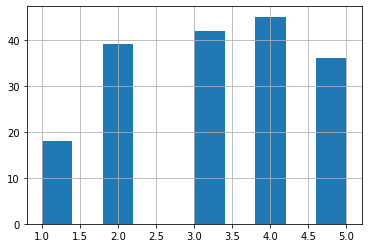

In [58]:
new_df['review'].hist()

In [74]:
def augment_data(df, max_count=42):
    n_iter = 0
    childs = []
    
    for rand_review in [1,2,3,4,5]:
        review_len = 0
        
        while review_len < max_count:
            parents = df[df['review'] == rand_review].sample(2)

            parents_contain_zeroes = np.any(parents.iloc[:,:2].to_numpy() == 0)

            if parents_contain_zeroes:
                continue

            cross = [0, 0]
            cross.extend(np.random.randint(2, size=5))

            childs_dict = {}

            for i, feature in enumerate(features):
                childs_dict[feature] = [
                    parents.iloc[cross[i]][feature],
                    parents.iloc[int(cross[i] != 1)][feature],
                ]

            childs_dict['review'] = [rand_review, rand_review]

            if isinstance(childs, list):
                childs = pd.DataFrame(data=childs_dict)
            else:
                childs = pd.concat([
                    childs,
                    pd.DataFrame(data=childs_dict)
                ])
            
            review_len = childs[childs['review'] == rand_review].shape[0] + df[df['review'] == rand_review].shape[0]
    return pd.concat([df, childs]).reset_index(drop=True).sample(frac=1)

/home/sviperm/Documents/GitHub/moscow_leaders_hackathon2020/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


<AxesSubplot:>

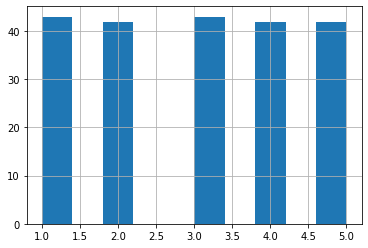

In [75]:
target = 'review'
features = ['true_mask_pixels', 'pred_mask_pixels', 'DICE', 'TP', 'FP', 'REFVOL', 'MUTINF']

df = new_df[features + [target]]
df.loc[mistakes.index, target] = 1

df_train, df_test = train_test_split(df, train_size=0.5, stratify=df[target])

df_train = augment_data(df_train)

display(df_train['review'].hist())
plt.show()

<AxesSubplot:>

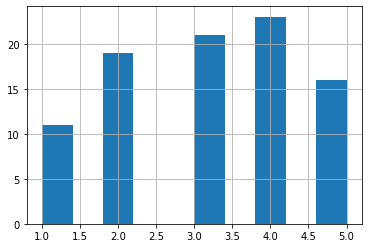

In [63]:
display(df_test['review'].hist())
plt.show()

In [79]:
results = []
models = []

target = 'review'
features = ['true_mask_pixels', 'pred_mask_pixels', 'DICE', 'TP', 'FP', 'REFVOL', 'MUTINF']

df = new_df[features + [target]]
df.loc[mistakes.index, target] = 1

for _ in tqdm(range(100)):
    df_train, df_test = train_test_split(df, train_size=0.5, stratify=df[target])
    
    df_train = augment_data(df_train)
    
#     display(df_train['review'].hist())
#     plt.show()

    train_pool = Pool(df_train[features], label=df_train[target])
    test_pool = Pool(df_test[features], label=df_test[target])

    cb_mae = CatBoostRegressor(loss_function='MAE', silent=True)
    cb_mae.fit(train_pool, eval_set=test_pool)#, plot=True)

    cb_mae_pred_rint = np.rint(cb_mae.predict(test_pool))
    
    models.append(cb_mae)    
    results.append(eval_metric(df_test[target].to_numpy(), cb_mae_pred_rint, 'MAE'))
    
print('mae_rint max\t', np.amax(results))
print('mae_rint loss\t', np.mean(results))
print('mae_rint min\t', np.amin(results))

/home/sviperm/Documents/GitHub/moscow_leaders_hackathon2020/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)



mae_rint max	 1.0333326444444455
mae_rint loss	 0.8482216187777785
mae_rint min	 0.6888884222222228


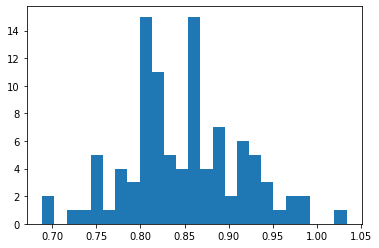

In [82]:
plt.hist(np.reshape(results, (1, -1))[0], bins=25)
plt.show()